In [ ]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
import nltk

# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# === 1. Load Dataset ===
df = pd.read_csv("")

# === 2. Preprocessing Function ===
def clean_text(text):
    text = str(text).lower()                          # lowercasing
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)                 # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)               # remove punctuation
    text = re.sub(r'\d+', '', text)                   # remove numbers
    tokens = text.split()                             # tokenization
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)
# Clean labels
df["label"] = df["label"].str.strip().str.lower()  # normalize case + remove spaces

# Fix spelling issues
df["label"] = df["label"].replace({
    "negetive": "negative"  # unify spelling
})

# Optional: check unique labels
print("Unique labels after cleaning:", df["label"].unique())

# === 3. Encode Labels ===
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

X = df["clean_text"]
y = df["label"]

# === 4. TF–IDF Vectorization ===
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# === 5. Random Oversampling to balance dataset ===
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_tfidf, y)

# === 6. Define Models ===
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# === 7. Cross-Validation Setup ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === 8. Metrics to Evaluate ===
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro',
    'roc_auc': 'roc_auc_ovr'
}

# === 9. Train and Evaluate Models ===
results = {}
for name, model in models.items():
    scores = cross_validate(model, X_balanced, y_balanced, cv=cv, scoring=scoring)
    results[name] = {
        "Accuracy": scores['test_accuracy'].mean(),
        "Precision": scores['test_precision'].mean(),
        "Recall": scores['test_recall'].mean(),
        "F1": scores['test_f1'].mean(),
        "AUC": scores['test_roc_auc'].mean()
    }

# === 10. Display Results ===
display(results)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Unique labels after cleaning: ['neutral' 'negative' 'positive']


{'KNN': {'Accuracy': np.float64(0.6335680751173709),
  'Precision': np.float64(0.7688842225453532),
  'Recall': np.float64(0.6335680751173709),
  'F1': np.float64(0.6211214228532526),
  'AUC': np.float64(0.8627148011307281)},
 'Logistic Regression': {'Accuracy': np.float64(0.868075117370892),
  'Precision': np.float64(0.8708452037932768),
  'Recall': np.float64(0.868075117370892),
  'F1': np.float64(0.8680697212987727),
  'AUC': np.float64(0.959178899689215)},
 'Decision Tree': {'Accuracy': np.float64(0.8970657276995306),
  'Precision': np.float64(0.9001873022558649),
  'Recall': np.float64(0.8970657276995306),
  'F1': np.float64(0.8959890780795542),
  'AUC': np.float64(0.934519440587185)}}

In [ ]:
# Show mapping
print("LabelEncoder classes:", le.classes_)
for i, cls in enumerate(le.classes_):
    print(f"{i} → {cls}")

LabelEncoder classes: ['negative' 'neutral' 'positive']
0 → negative
1 → neutral
2 → positive


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Manual 10-fold loop
fold_results = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X_balanced, y_balanced), 1):
    print(f"\n=== Fold {fold} ===")

    X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]

    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="macro")
        rec = recall_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")
        auc = roc_auc_score(y_test, y_prob, multi_class="ovr") if y_prob is not None else None

        print(f"{name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

        # Store results
        fold_results.append({
            "Fold": fold,
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "AUC": auc
        })

# Convert to DataFrame for summary
fold_results_df = pd.DataFrame(fold_results)
print("\n=== All Fold Results ===\n")
print(fold_results_df)


=== Fold 1 ===
KNN: Accuracy=0.6432, Precision=0.7677, Recall=0.6432, F1=0.6325, AUC=0.8606
Logistic Regression: Accuracy=0.8732, Precision=0.8748, Recall=0.8732, F1=0.8735, AUC=0.9575
Decision Tree: Accuracy=0.9108, Precision=0.9125, Recall=0.9108, F1=0.9104, AUC=0.9414

=== Fold 2 ===
KNN: Accuracy=0.6279, Precision=0.7573, Recall=0.6279, F1=0.6133, AUC=0.8594
Logistic Regression: Accuracy=0.8415, Precision=0.8496, Recall=0.8415, F1=0.8411, AUC=0.9597
Decision Tree: Accuracy=0.8838, Precision=0.8882, Recall=0.8838, F1=0.8822, AUC=0.9276

=== Fold 3 ===
KNN: Accuracy=0.6197, Precision=0.7531, Recall=0.6197, F1=0.6092, AUC=0.8659
Logistic Regression: Accuracy=0.8627, Precision=0.8636, Recall=0.8627, F1=0.8625, AUC=0.9559
Decision Tree: Accuracy=0.8944, Precision=0.8986, Recall=0.8944, F1=0.8942, AUC=0.9346

=== Fold 4 ===
KNN: Accuracy=0.6303, Precision=0.7611, Recall=0.6303, F1=0.6170, AUC=0.8545
Logistic Regression: Accuracy=0.8756, Precision=0.8768, Recall=0.8756, F1=0.8756, AUC=0.

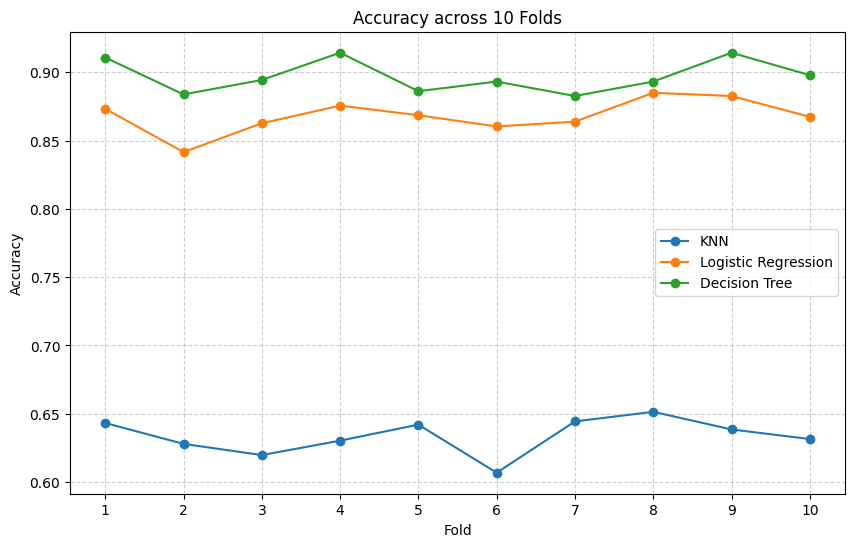

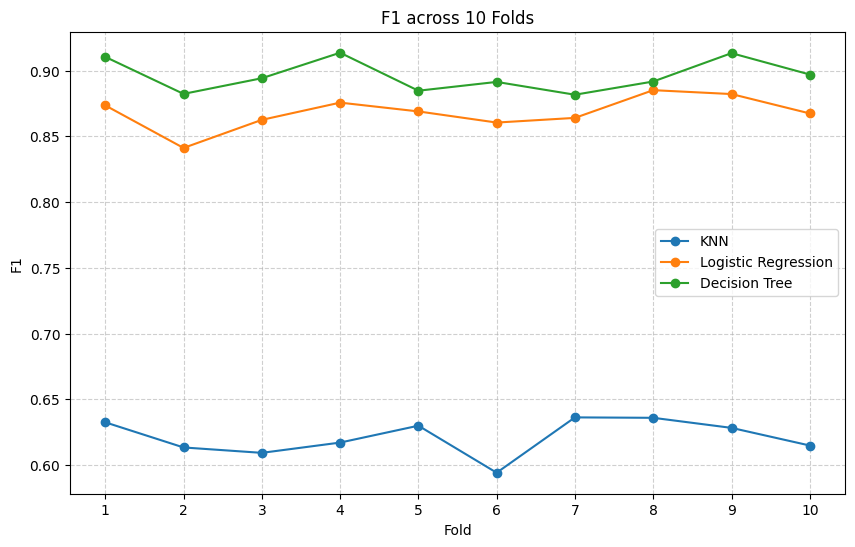

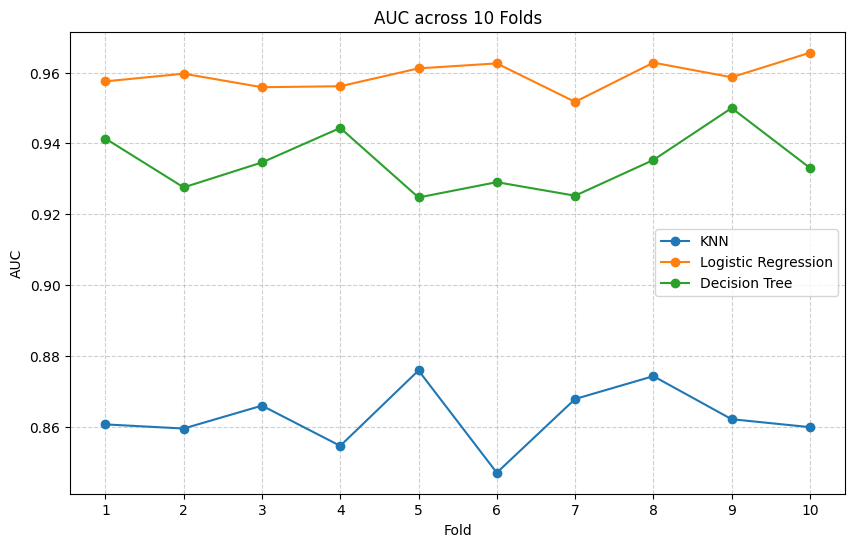

In [ ]:
import matplotlib.pyplot as plt

# Set metrics you want to visualize
metrics = ["Accuracy", "F1", "AUC"]

for metric in metrics:
    plt.figure(figsize=(10, 6))

    for model in fold_results_df["Model"].unique():
        subset = fold_results_df[fold_results_df["Model"] == model]
        plt.plot(subset["Fold"], subset[metric], marker="o", label=model)

    plt.title(f"{metric} across 10 Folds")
    plt.xlabel("Fold")
    plt.ylabel(metric)
    plt.xticks(range(1, 11))
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()



In [ ]:
# Summary table with mean ± std per metric
summary = fold_results_df.groupby("Model").agg(
    Accuracy_mean=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    Precision_mean=("Precision", "mean"),
    Precision_std=("Precision", "std"),
    Recall_mean=("Recall", "mean"),
    Recall_std=("Recall", "std"),
    F1_mean=("F1", "mean"),
    F1_std=("F1", "std"),
    AUC_mean=("AUC", "mean"),
    AUC_std=("AUC", "std"),
)

# Format nicely (mean ± std)
summary_formatted = summary.copy()
for col in summary.columns:
    if "_mean" in col:
        base = col.replace("_mean", "")
        summary_formatted[base] = (
            summary[f"{base}_mean"].round(4).astype(str)
            + " ± "
            + summary[f"{base}_std"].round(4).astype(str)
        )

# Keep only the formatted columns
summary_final = summary_formatted[["Accuracy","Precision","Recall","F1","AUC"]]

print("\n=== Model Performance Summary (Mean ± Std across 10 folds) ===\n")
print(summary_final)


=== Model Performance Summary (Mean ± Std across 10 folds) ===

                            Accuracy        Precision           Recall  \
Model                                                                    
Decision Tree        0.8971 ± 0.0121  0.9002 ± 0.0118  0.8971 ± 0.0121   
KNN                  0.6336 ± 0.0132  0.7689 ± 0.0095  0.6336 ± 0.0132   
Logistic Regression  0.8681 ± 0.0124   0.8708 ± 0.011  0.8681 ± 0.0124   

                                  F1              AUC  
Model                                                  
Decision Tree         0.896 ± 0.0124  0.9345 ± 0.0085  
KNN                  0.6211 ± 0.0137  0.8627 ± 0.0087  
Logistic Regression  0.8681 ± 0.0125  0.9592 ± 0.0041  


In [ ]:
# Summary table with mean ± std
summary = fold_results_df.groupby("Model").agg(
    Accuracy_mean=("Accuracy", "mean"),
    Accuracy_std=("Accuracy", "std"),
    Precision_mean=("Precision", "mean"),
    Precision_std=("Precision", "std"),
    Recall_mean=("Recall", "mean"),
    Recall_std=("Recall", "std"),
    F1_mean=("F1", "mean"),
    F1_std=("F1", "std"),
    AUC_mean=("AUC", "mean"),
    AUC_std=("AUC", "std"),
)

# Format as "mean ± std"
summary_formatted = summary.copy()
for col in summary.columns:
    if "_mean" in col:
        base = col.replace("_mean", "")
        summary_formatted[base] = (
            summary[f"{base}_mean"].round(4).astype(str)
            + " ± "
            + summary[f"{base}_std"].round(4).astype(str)
        )

# Keep only formatted columns
summary_final = summary_formatted[["Accuracy", "Precision", "Recall", "F1", "AUC"]]

print("\n=== Model Performance Summary (Mean ± Std across 10 folds) ===\n")
display(
    summary_final.style.highlight_max(axis=0, color="lightgreen")
)


=== Model Performance Summary (Mean ± Std across 10 folds) ===



,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Decision Tree,0.8971 ± 0.0121,0.9002 ± 0.0118,0.8971 ± 0.0121,0.896 ± 0.0124,0.9345 ± 0.0085
KNN,0.6336 ± 0.0132,0.7689 ± 0.0095,0.6336 ± 0.0132,0.6211 ± 0.0137,0.8627 ± 0.0087
Logistic Regression,0.8681 ± 0.0124,0.8708 ± 0.011,0.8681 ± 0.0124,0.8681 ± 0.0125,0.9592 ± 0.0041


/tmp/ipython-input-58809235.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")
/tmp/ipython-input-58809235.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced, palette="Set2")


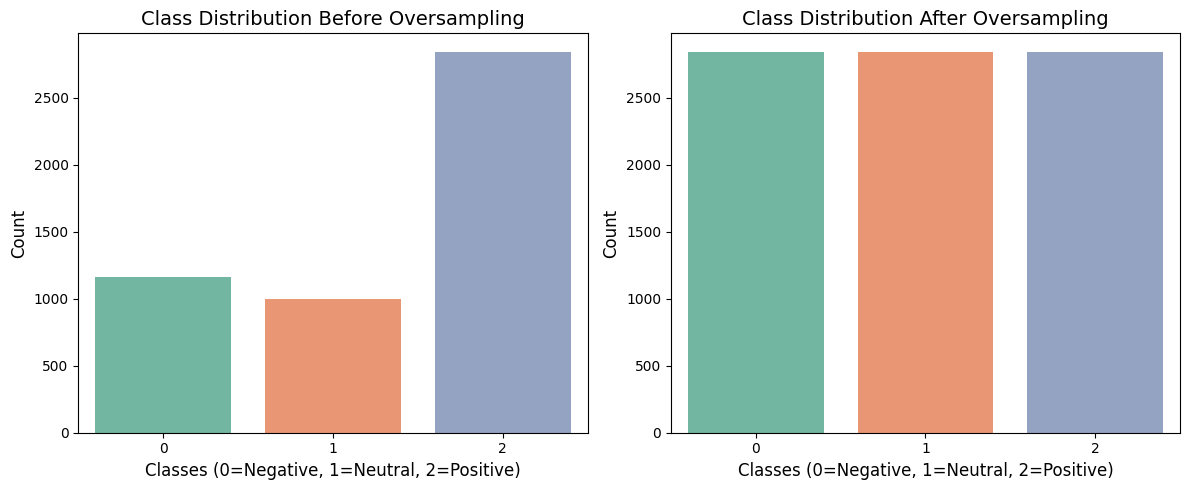

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution before oversampling
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x=y, palette="Set2")
plt.title("Class Distribution Before Oversampling", fontsize=14)
plt.xlabel("Classes (0=Negative, 1=Neutral, 2=Positive)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Class distribution after oversampling
plt.subplot(1,2,2)
sns.countplot(x=y_balanced, palette="Set2")
plt.title("Class Distribution After Oversampling", fontsize=14)
plt.xlabel("Classes (0=Negative, 1=Neutral, 2=Positive)", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

df = df[df['label'].isin([0, 1, 2])]

# Show class distribution before oversampling
print("Class distribution BEFORE oversampling:")
print(df['label'].value_counts())

# Apply oversampling
X = df['clean_text']
y = df['label']

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X.values.reshape(-1, 1), y)

# Convert back to DataFrame
df_resampled = pd.DataFrame({"clean_text": X_res.flatten(), "label": y_res})

# Show class distribution after oversampling
print("\nClass distribution AFTER oversampling:")
print(df_resampled['label'].value_counts())

Class distribution BEFORE oversampling:
label
2    2840
0    1165
1     995
Name: count, dtype: int64

Class distribution AFTER oversampling:
label
1    2840
0    2840
2    2840
Name: count, dtype: int64


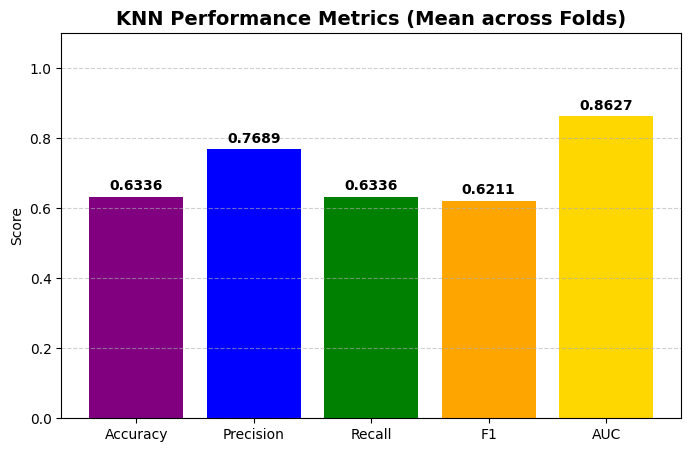

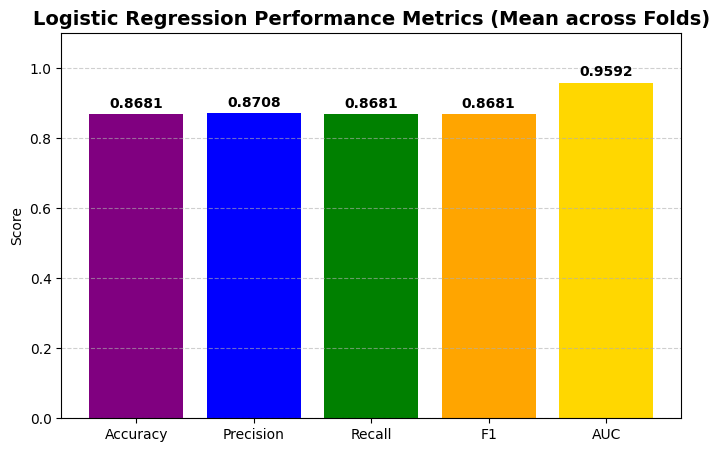

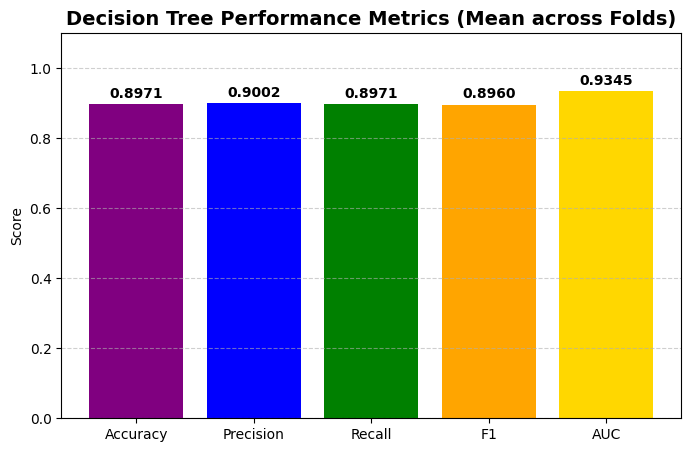

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the results (from the dataframe we saved earlier)
df_results = fold_results_df # Use the existing DataFrame

# Define metrics you want to plot
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"] # Corrected metric names to match DataFrame columns

# Loop through each model and plot separately
for model_name in df_results["Model"].unique():
    subset = df_results[df_results["Model"] == model_name]
    # Calculate the mean of each metric for the current model across all folds
    mean_metrics = subset[metrics].mean()

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, mean_metrics.values, color=["purple", "blue", "green", "orange", "gold"])

    # Annotate each bar with its value
    for bar, val in zip(bars, mean_metrics.values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f"{val:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.ylim(0, 1.1)  # keep scale consistent
    plt.title(f"{model_name} Performance Metrics (Mean across Folds)", fontsize=14, fontweight="bold")
    plt.ylabel("Score")
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.show()

In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.6 MB/s eta 0:00:00


In [ ]:
print("LabelEncoder classes:", le.classes_)
for i, cls in enumerate(le.classes_):
    print(f"{i} → {cls}")

LabelEncoder classes: ['negative' 'neutral' 'positive']
0 → negative
1 → neutral
2 → positive


LabelEncoder classes: ['negative' 'neutral' 'positive']

=== Model Evaluation (10-Fold CV, with Oversampling) ===

                     Accuracy  Precision    Recall        F1       AUC
KNN                  0.600000   0.784139  0.600000  0.588518  0.861265
Logistic Regression  0.869014   0.870800  0.869014  0.868974  0.961127
Decision Tree        0.895892   0.899506  0.895892  0.894496  0.928602


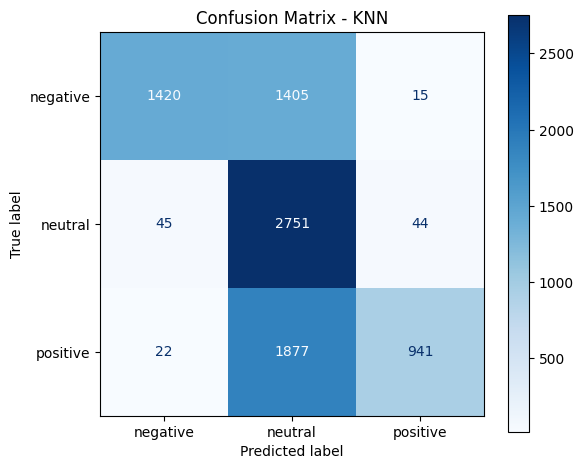

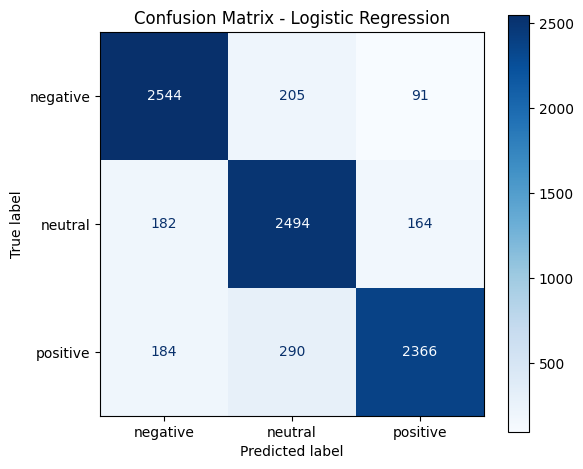

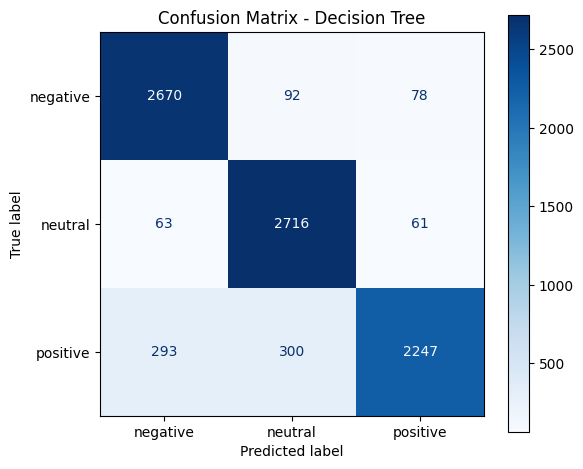

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np

# === 1. Load Dataset ===
df = pd.read_csv("/content/drive/MyDrive/dataset/new ML.csv")  # must contain "text", "label"

# === 2. Clean Labels ===
df["label"] = df["label"].str.strip().str.lower()
df["label"] = df["label"].replace({"negetive": "negative"})  # fix typo

# === 3. Encode Labels ===
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])
print("LabelEncoder classes:", le.classes_)

X = df["text"]
y = df["label"]

# === 4. TF–IDF Vectorization ===
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# === 5. Oversampling to balance ===
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_tfidf, y)

# === 6. Define Models ===
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# === 7. Cross-validation setup ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === 8. Storage for results ===
results = {}
all_true_labels = {name: [] for name in models.keys()}
all_pred_labels = {name: [] for name in models.keys()}

# === 9. Run CV, collect metrics + predictions ===
for name, model in models.items():
    acc, prec, rec, f1s, aucs = [], [], [], [], []

    for train_idx, test_idx in cv.split(X_balanced, y_balanced):
        X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
        y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Store predictions for confusion matrix
        all_true_labels[name].extend(y_test)
        all_pred_labels[name].extend(y_pred)

        # Compute metrics
        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred, average="macro", zero_division=0))
        rec.append(recall_score(y_test, y_pred, average="macro", zero_division=0))
        f1s.append(f1_score(y_test, y_pred, average="macro", zero_division=0))

        # AUC (handle multi-class case)
        try:
            aucs.append(roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr"))
        except Exception:
            aucs.append(np.nan)

    results[name] = {
        "Accuracy": np.mean(acc),
        "Precision": np.mean(prec),
        "Recall": np.mean(rec),
        "F1": np.mean(f1s),
        "AUC": np.nanmean(aucs)
    }

# === 10. Display Metrics ===
results_df = pd.DataFrame(results).T
print("\n=== Model Evaluation (10-Fold CV, with Oversampling) ===\n")
print(results_df)

# === 11. Confusion Matrices ===
class_names = list(le.classes_)
for name in models.keys():
    cm = confusion_matrix(all_true_labels[name], all_pred_labels[name], labels=range(len(class_names)))

    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
import pandas as pd
import numpy as np

# === 1. Ensure labels are cleaned ===
# These lines are removed as the label column is already encoded
# df["label"] = df["label"].str.strip().str.lower()
# df["label"] = df["label"].replace({"negetive": "negative"})  # fix spelling

# le = LabelEncoder() # LabelEncoder is already fitted in the first cell
# df["label"] = le.fit_transform(df["label"]) # Label is already transformed

class_names = list(le.classes_)
print("Final Label Mapping:")
for i, cls in enumerate(class_names):
    print(f"{i} → {cls}")

# === 2. Metrics table (from your results dictionary) ===
# Assuming 'results' dictionary contains the mean and std of metrics per model from cross_validate
# If 'results' contains fold-wise scores, you might need to re-calculate the summary here
# Based on the output of cell ci2HHwJIStAM, 'results' contains the mean metrics, let's use that.
# We will use the 'summary_final' DataFrame generated in cell 2dad3816 which is already formatted.
# If summary_final is not available, regenerate it here.
if 'summary_final' not in locals():
    print("Regenerating summary_final DataFrame...")
    summary = fold_results_df.groupby("Model").agg(
        Accuracy_mean=("Accuracy", "mean"),
        Accuracy_std=("Accuracy", "std"),
        Precision_mean=("Precision", "mean"),
        Precision_std=("Precision", "std"),
        Recall_mean=("Recall", "mean"),
        Recall_std=("Recall", "std"),
        F1_mean=("F1", "mean"),
        F1_std=("F1", "std"),
        AUC_mean=("AUC", "mean"),
        AUC_std=("AUC", "std"),
    )
    summary_formatted = summary.copy()
    for col in summary.columns:
        if "_mean" in col:
            base = col.replace("_mean", "")
            summary_formatted[base] = (
                summary[f"{base}_mean"].round(4).astype(str)
                + " ± "
                + summary[f"{base}_std"].round(4).astype(str)
            )
    summary_final = summary_formatted[["Accuracy", "Precision", "Recall", "F1", "AUC"]]


pdf_filename = "Model_Evaluation_Report.pdf"
doc = SimpleDocTemplate(pdf_filename, pagesize=A4)
styles = getSampleStyleSheet()
flowables = []

# --- Title ---
flowables.append(Paragraph("<b>Model Evaluation Report</b>", styles["Title"]))
flowables.append(Spacer(1, 12))

# --- Label Mapping ---
flowables.append(Paragraph("<b>Label Mapping:</b>", styles["Heading2"]))
mapping_text = ", ".join([f"{i} = {cls}" for i, cls in enumerate(class_names)])
flowables.append(Paragraph(mapping_text, styles["Normal"]))
flowables.append(Spacer(1, 12))

# --- Metrics Table ---
flowables.append(Paragraph("<b>Evaluation Metrics (10-Fold CV with Oversampling)</b>", styles["Heading2"]))
# Prepare data for the table from the summary_final DataFrame
summary_data = [["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]]
for index, row in summary_final.iterrows():
    summary_data.append([
        index,
        row['Accuracy'],
        row['Precision'],
        row['Recall'],
        row['F1'],
        row['AUC']
    ])


t = Table(summary_data)
t.setStyle(TableStyle([
    ("BACKGROUND", (0, 0), (-1, 0), colors.grey),
    ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
    ("ALIGN", (0, 0), (-1, -1), "CENTER"),
    ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
    ("GRID", (0, 0), (-1, -1), 0.5, colors.black),
]))
flowables.append(t)
flowables.append(Spacer(1, 12))

# --- Confusion Matrices ---
# Assuming 'results' dictionary from cell lVPmlbxsd-yg contains the aggregated true and predicted labels
for name in models.keys():
    if name in results:
        all_true_labels = []
        all_pred_labels = []
        for y_true, y_pred in results[name]:
             all_true_labels.extend(y_true)
             all_pred_labels.extend(y_pred)

        cm = confusion_matrix(all_true_labels, all_pred_labels, labels=range(len(class_names)))

        # Save confusion matrix as image
        plt.figure(figsize=(6, 5))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
        plt.title(f"Confusion Matrix - {name}")
        plt.tight_layout()
        img_filename = f"cm_{name.replace(' ', '_')}.png" # Use cleaned name for filename
        plt.savefig(img_filename, dpi=300)
        plt.close()

        # Add to PDF
        flowables.append(Paragraph(f"<b>Confusion Matrix - {name}</b>", styles["Heading2"]))
        flowables.append(Image(img_filename, width=400, height=300))
        flowables.append(Spacer(1, 12))
    else:
        print(f"No aggregated results found for model: {name}")


# --- Add plots (using plot_files) ---
# Assuming plot_files contains the paths to the saved plot images (from cell YSmk4qQVtFBH)
# If plot_files is not available, you would need to regenerate the plots and save them here.
if 'plot_files' in locals():
    elements.append(Paragraph("📈 Performance Visualizations:", styles['Heading2']))
    for plot_path in plot_files:
        elements.append(Image(plot_path, width=400, height=300))
        elements.append(Spacer(1, 12))
else:
    print("Plot files not found. Skipping performance visualizations in PDF.")


# --- Build PDF ---
doc.build(flowables)
print(f"✅ PDF report saved as {pdf_filename}")

Final Label Mapping:
0 → negative
1 → neutral
2 → positive
✅ PDF report saved as Model_Evaluation_Report.pdf


In [ ]:
from google.colab import files
files.download("Model_Evaluation_Report.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>